In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from dataset_manager import MeteoDataset


class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

##### Dane ze strony http://meteo.ftj.agh.edu.pl/
 * zakres od 3.07.2018 do 3.08.2022
 * pomiar co 24h
 * średnia wartość pyłów zawieszonych PM10
 * łączny rozmiar: 1472 pomiary

Text(0, 0.5, 'PM10 [µg/m3]')

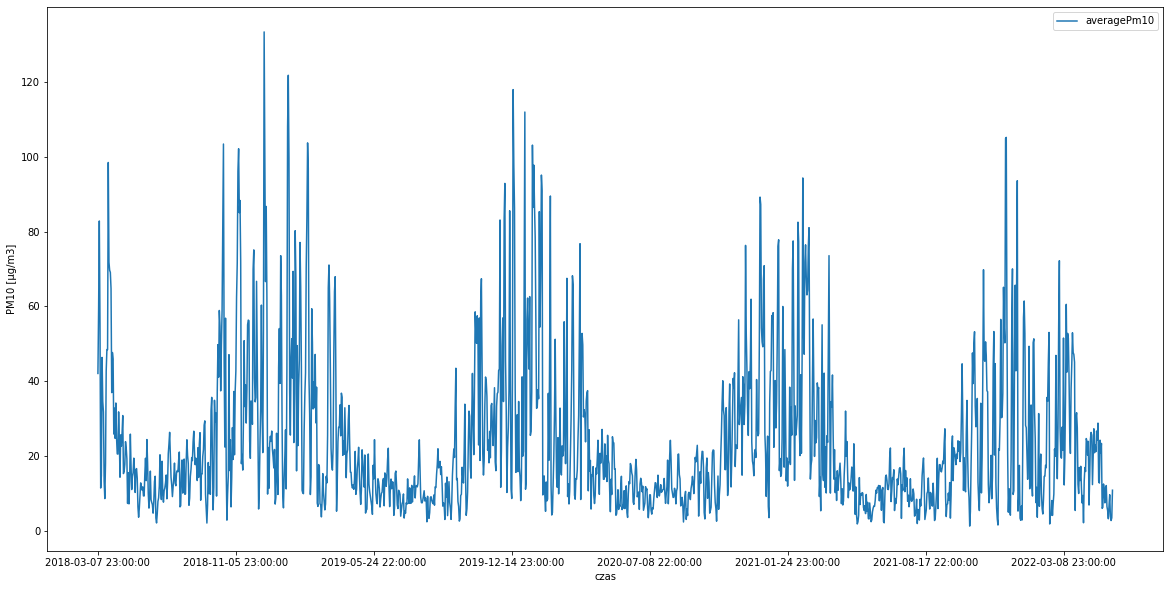

In [27]:
dataset = MeteoDataset("C:\\Users\\AnnaMaria\\Desktop\\Fizyka Systemu Ziemi\\data_pm10.csv")
data = dataset.df.values
fig, ax = plt.subplots(figsize=(20,10))
dataset.df.plot(ax=ax)
ax.set_xlabel("czas")
ax.set_ylabel("PM10 [µg/m3]")

* Z zestawu danych tworzone są sekwencje o wybranej długości
* Model po "przeanalizowaniu" sekwencji będzie przewidywał kolejną wartość
* Dlatego dla każdej sekwencji zapisywana jest także wartość następująca po niej (y_pred)
* Model będzie mógł porównać przewidzianą przez siebie wartość z tą faktyczną i na tej podstawie poprawić wagi

In [28]:
def create_sequences(data, seq_length):
    X_train = []
    y_pred = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        X_train.append(_x)
        y_pred.append(_y)

    return np.array(X_train), np.array(y_pred)

* Skalowanie wartości do zakresu od 0 do 1
* Podzielenie danych na sekwencje
* Podzielenie danych na treningowe i testowe
* Zamienienie danych na tensory z biblioteki PyTorch

In [29]:
sc = MinMaxScaler() 
training_data = sc.fit_transform(data)

seq_length = 16
x, y = create_sequences(training_data, seq_length)
ratio = 0.8
N_train = (int)(ratio*len(x))
print(f"Liczba pomiarów: {len(data)} | Część wydzielona do uczenia: {N_train}")
print(f"Długość sekwencji: {seq_length} | Liczba sekwencji: {len(x)}")

X_train = x[:N_train]
X_test = x[N_train:]
y_train = y[:N_train]
y_test = y[N_train:]

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(X_train)))
trainY = Variable(torch.Tensor(np.array(y_train)))
testX = Variable(torch.Tensor(np.array(X_test)))
testY = Variable(torch.Tensor(np.array(y_test)))

Liczba pomiarów: 1472 | Część wydzielona do uczenia: 1164
Długość sekwencji: 16 | Liczba sekwencji: 1455


* Ustawienie hiperparametrów

In [30]:
num_epochs = 10000
learning_rate = 0.01

input_size = 1
hidden_size = 7
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, seq_length)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

* Trening

In [31]:
loss_val = []
epochs = [epoch for epoch in range(num_epochs) if epoch % 100 == 0]

for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
      loss_val.append(loss.item())

Epoch: 0, loss: 0.04753
Epoch: 100, loss: 0.01199
Epoch: 200, loss: 0.01082
Epoch: 300, loss: 0.01077
Epoch: 400, loss: 0.01073
Epoch: 500, loss: 0.01069
Epoch: 600, loss: 0.01063
Epoch: 700, loss: 0.01057
Epoch: 800, loss: 0.01048
Epoch: 900, loss: 0.01010
Epoch: 1000, loss: 0.00955
Epoch: 1100, loss: 0.00889
Epoch: 1200, loss: 0.00787
Epoch: 1300, loss: 0.00731
Epoch: 1400, loss: 0.00683
Epoch: 1500, loss: 0.00622
Epoch: 1600, loss: 0.00608
Epoch: 1700, loss: 0.00577
Epoch: 1800, loss: 0.00545
Epoch: 1900, loss: 0.00527
Epoch: 2000, loss: 0.00507
Epoch: 2100, loss: 0.00520
Epoch: 2200, loss: 0.00503
Epoch: 2300, loss: 0.00483
Epoch: 2400, loss: 0.00477
Epoch: 2500, loss: 0.00471
Epoch: 2600, loss: 0.00468
Epoch: 2700, loss: 0.00461
Epoch: 2800, loss: 0.00472
Epoch: 2900, loss: 0.00457
Epoch: 3000, loss: 0.00452
Epoch: 3100, loss: 0.00458
Epoch: 3200, loss: 0.00441
Epoch: 3300, loss: 0.00445
Epoch: 3400, loss: 0.00439
Epoch: 3500, loss: 0.00439
Epoch: 3600, loss: 0.00432
Epoch: 3700, 

Text(0, 0.5, 'loss')

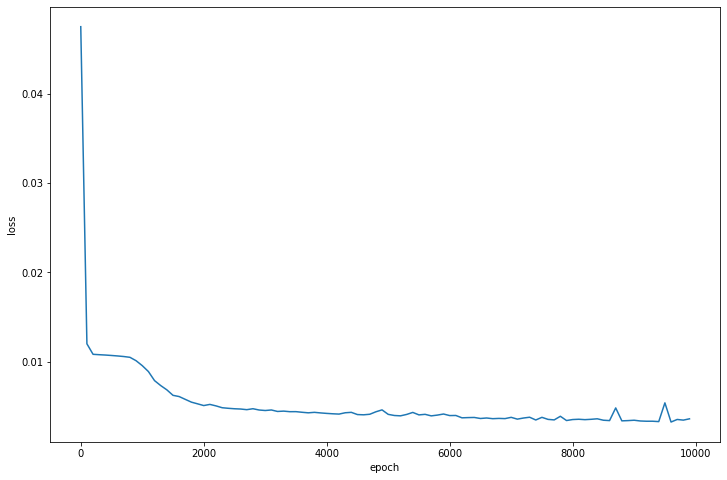

In [32]:
plt.figure(figsize=(12,8))
plt.plot(epochs, loss_val)
plt.xlabel("epoch")
plt.ylabel("loss")

* Sprawdzenie na danych testowych

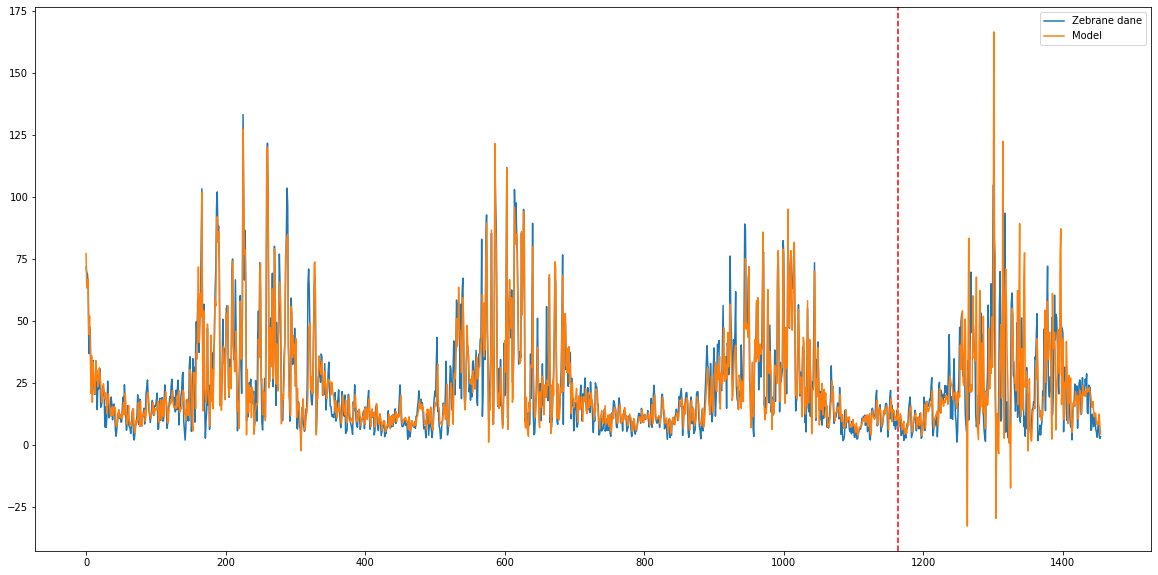

In [33]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
data_observed = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
data_observed= sc.inverse_transform(data_observed)

fig, ax = plt.subplots(figsize=(20,10))

ax.axvline(x=N_train, c='r', linestyle='--')

ax.plot(data_observed, label="Zebrane dane")
ax.plot(data_predict, label="Model")
#ax.set_xlim([1200,1500])
ax.legend()

* Obliczenia błędów

In [39]:
print(f"Mean absolute error: {mae(data_observed,data_predict)}")
print(f"Mean squared error: {mse(data_observed,data_predict)}")

print(f"Root mean squared error: {mse(data_observed,data_predict,squared=False)}")
print(f"Model standard deviation: {np.std(data_predict)}")
print(f"Observed data standard deviation: {np.std(data_observed)}")
print(f"R2 score: {r2(data_observed,data_predict)}")

Mean absolute error: 6.922311782836914
Mean squared error: 125.91064453125
Root mean squared error: 11.220991134643555
Model standard deviation: 19.40569305419922
Observed data standard deviation: 20.23118019104004
R2 score: 0.6923761788486755


* Zamiana osi OX na czasową

<AxesSubplot:xlabel='time'>

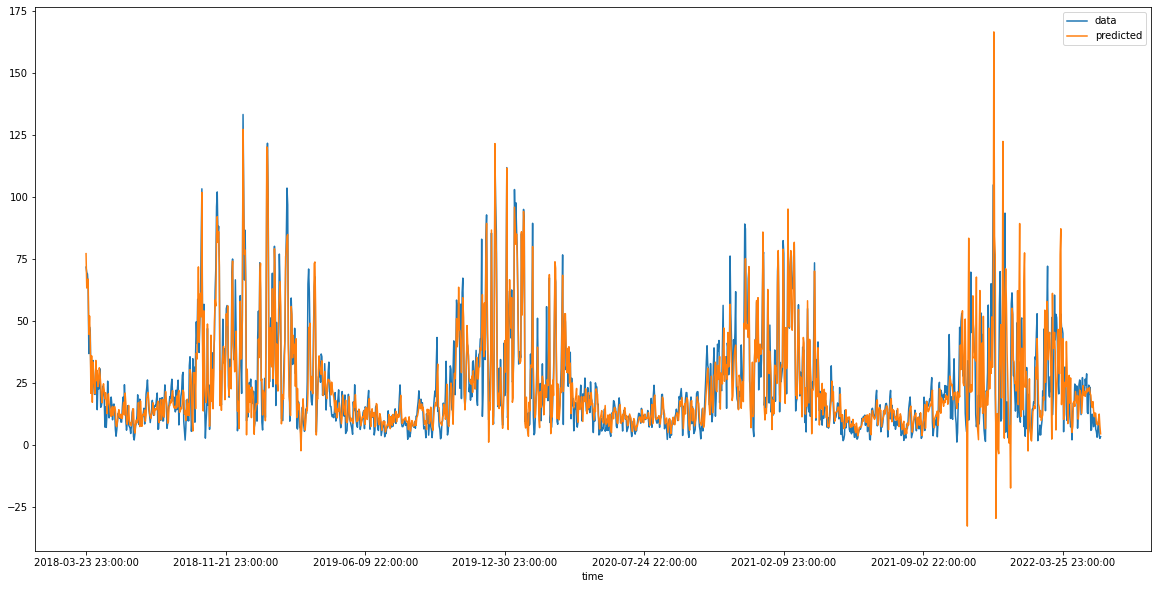

In [35]:
data_dict = {}
data_dict['time'] = [dataset.df.index[i+seq_length] for i in range(len(data_predict))]
data_dict['data'] = [data_observed[i][0] for i in range(len(data_predict))]
data_dict['predicted'] = [data_predict[i][0] for i in range(len(data_predict))]

data_df = pd.DataFrame.from_dict(data_dict)
data_df = data_df.set_index("time")
data_df.plot(figsize=(20,10))